In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import random
from scipy import stats

# load data from matlab file mackeyglass time series
loaded_mat = scipy.io.loadmat('MGTimeseries_dde23_tau17.mat')
data_tau17 = loaded_mat['MGseries_dde23_tau17'][0]
data_tau50 = loaded_mat['MGseries_dde23_tau50'][0]

# clean dataset
data = pd.DataFrame({'tau17': data_tau17}) # use tau=17 first
data.index = data.index + 1

In [315]:
# split data set
training_data = data.loc[1:3001]
testing_data = data.loc[3002:]
dummy_data_train = data.loc[1:11]
dummy_data_test = data.loc[12:20]

In [336]:
def gen_matrix(shape, sd, mean, sparsity):
    #seed = 100
    m = shape[0]
    n = shape[1]
    rvs = stats.norm(loc=mean, scale=sd).rvs
    #M = random(m, n, density=sparsity, random_state=seed, data_rvs=rvs).A
    M = random(m, n, density=sparsity, data_rvs=rvs).A
    return M

def spectral_radius(M):
    max_abs_eigenvalue = -1
    eigenvalues, eigenvectors = np.linalg.eig(M)
    for eigenvalue in eigenvalues:
        if abs(eigenvalue) > max_abs_eigenvalue:
            max_abs_eigenvalue = abs(eigenvalue)
    return max_abs_eigenvalue

In [389]:
N = 1001    # plus 1, for bias term
gamma = 2.5
s = 1

A = gen_matrix((N,N), sd=1, mean=0, sparsity=0.01)
C = gen_matrix((N,1), sd=1, mean=0, sparsity=0.01)
zeta = np.random.rand(N,1)

x_0 = np.zeros(shape=(N,1), dtype=float)

def sigma(value):
    return np.tanh(value)

In [397]:
N = 1001    # plus 1, for bias term
gamma = 0.5
s = 1

A = gen_matrix((N,N), sd=0.5, mean=0, sparsity=0.01)
C = gen_matrix((N,1), sd=0.5, mean=0, sparsity=0.01)
zeta = np.random.uniform(size=(N,1), low=-10**(-10), high=-10**(-10))

x_0 = np.zeros(shape=(N,1), dtype=float)

def sigma(value):
    return np.tanh(value)

In [398]:
A_sr = spectral_radius(A)
A = A*(1/A_sr)
desired_spec_rad = 0.8
A = A*desired_spec_rad

In [399]:
print(A)

[[ 0.          0.          0.         ...  0.          0.
  -0.54462863]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.2180558
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [376]:
A_sr

3.2332229032262685

In [309]:
# esn - state equation
def state(x_prev, z_curr):
    z_curr = np.atleast_2d(z_curr)
    x_curr = sigma(np.matmul(A, x_prev) + gamma*np.matmul(C, z_curr) + s*zeta)
    return x_curr

# esn - observation equation
def observation(x_curr, w, a):
    z_next = np.matmul(np.transpose(w), x_curr) + a
    return z_next

# incrementally store x and actual z values into matrix X and Z, output best weight solution
def regression_sol(ld):
    T = len(training_data)
    for t in range(1, T+1):
        if t == 1:
            x_curr = x_0
            X = np.array(x_curr)
            z_curr = training_data.loc[t]['tau17']
            Z = np.atleast_2d(np.array([z_curr]))
        else:
            x_curr = state(x_curr, z_curr)
            X = np.column_stack((X, x_curr))
            z_curr = training_data.loc[t]['tau17']
            Z = np.column_stack((Z, z_curr))
    
    X = np.row_stack((X, np.ones(shape=(1, T))))
    X_transpose = X.transpose()
    Z_transpose = Z.transpose()
    
    XZ_transpose = np.matmul(X, Z_transpose)
    inverse_term = np.linalg.inv(np.matmul(X, X_transpose) - ld*np.identity(N+1))
    W_best = np.matmul(inverse_term, XZ_transpose)
    
    return W_best

In [310]:
# output training error using selected weights and bias
def training_error(w, a):
    T = len(training_data)
    error = 0
    x_prev = x_0
    z_predictions = []
    z_actuals = []
    for t in range(1, T+1):
        z_curr_actual = training_data.loc[t]['tau17']
        z_curr_prediction = observation(x_prev, w, a)[0][0]
        error = error + (z_curr_actual - z_curr_prediction)**2
        z_predictions.append(z_curr_prediction)
        z_actuals.append(z_curr_actual)
        x_curr = state(x_prev, z_curr_actual)
        x_prev = x_curr
    
    plt.figure(figsize=(30,5))
    plt.plot(range(1,T+1), z_actuals, label="actual")
    plt.plot(range(1,T+1), z_predictions, label="predictions")
    plt.legend()
        
    return error/(T-1)

# predict and plot entire data set using weight and bias
def predict(w, a):
    T = len(training_data)
    T_bar = len(testing_data)
    
    x_prev = x_0
    
    z_predictions = []
    z_actuals = []
    
    testing_error = 0
    for t in range(1, T+1):
        z_curr_actual = training_data.loc[t]['tau17']
        z_curr_prediction = observation(x_prev, w, a)[0][0]
        z_predictions.append(z_curr_prediction)
        z_actuals.append(z_curr_actual)
        x_curr = state(x_prev, z_curr_actual)
        x_prev = x_curr

    for t_bar in range(T+1, T+T_bar+1):
        z_curr_actual = testing_data.loc[t_bar]['tau17']
        z_actuals.append(z_curr_actual)
        z_curr_prediction = observation(x_prev, w, a)[0][0]
        z_predictions.append(z_curr_prediction)
        testing_error = testing_error + (z_curr_actual - z_curr_prediction)**2
        x_curr = state(x_prev, z_curr_prediction)
        x_prev = x_curr

    plt.figure(figsize=(30,5))
    plt.plot(range(1,T+T_bar+1), z_actuals, label="actuals")
    plt.plot(range(1,T+T_bar+1), z_predictions, label="predictions")
    plt.legend()
    plt.axvline(3001, color='black', linestyle="--")
    
    return testing_error/T_bar #, z_predictions

In [400]:
x_0 = np.zeros(shape=(N,1), dtype=float)
params_best = regression_sol(0.9)

In [401]:
w_best = params_best[:-1, :]
a_best = params_best[-1, :][0]

0.000836826708615508

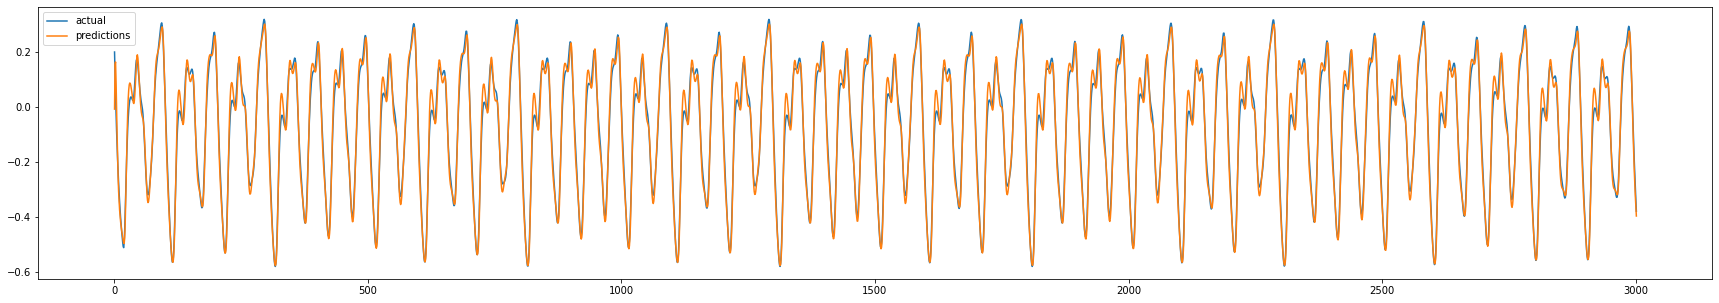

In [402]:
training_error(w_best, a_best)

6.173657552979239

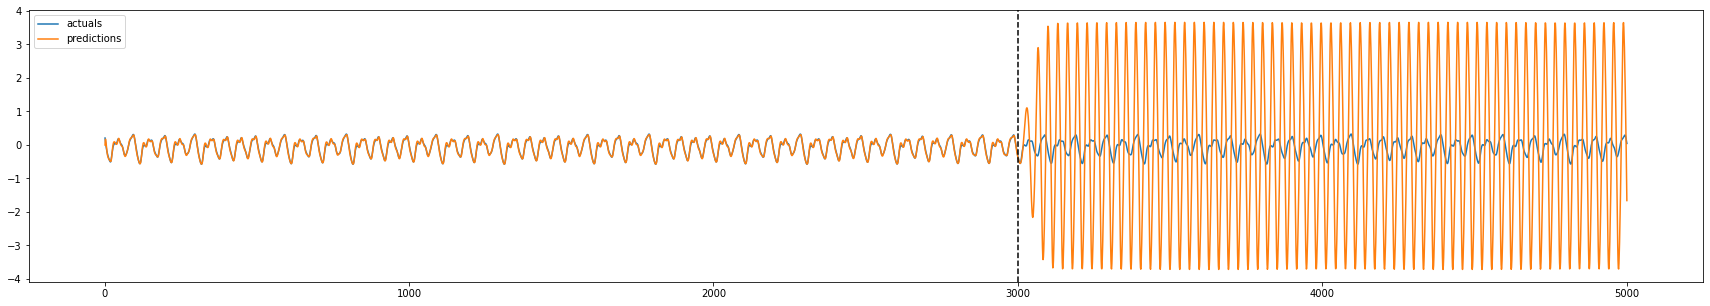

In [403]:
predict(w_best, a_best)